# Application of Graph Theory in Social Network Analysis among Himpunan Mahasiswa Informatika Institut Teknologi Bandung Class of 2023 on Instagram

**Author:** Refki Alfarizi 
**Date:** January 7, 2025

---

## Introduction

Social Network Analysis (SNA) is a methodological approach to understanding the structures of social relationships. By applying graph theory, we can model and analyze the interactions and relationships among individuals within a network. This study focuses on analyzing the Instagram network of the Himpunan Mahasiswa Informatika (Informatics Student Association) at Institut Teknologi Bandung (ITB), specifically the Class of 2023.

Instagram, being a widely used social media platform, provides a rich source of data for SNA. By leveraging Python and libraries such as Pandas and NetworkX, we can process and visualize the relationships among the members of this student association.

---

## Objectives

- **Data Loading:** Import existing Instagram data from CSV and JSON files.
- **Data Cleaning:** Handle cases such as duplicate edges and ensure data integrity.
- **Statistical Analysis:** Generate statistics related to the dataset (e.g., number of private accounts, followers distribution).
- **Graph Construction:** Build a social network graph representing the relationships among the users.
- **Visualization:** Create visual representations of the network to identify patterns and key influencers.
- **Graph Analysis:** Apply graph theory metrics to understand the network's properties.
- **Insight Generation:** Derive meaningful insights from the analysis to inform strategies or further research.

---

## Prerequisites

Before proceeding, ensure you have the following installed:

- **Python 3.7** or higher
- **Jupyter Notebook**
- **NetworkX**
- **Matplotlib**
- **Pandas**
- **NumPy**
- **Seaborn**
- **TQDM**

You can install the necessary Python packages using `pip`:

```bash
pip install networkx matplotlib pandas numpy seaborn tqdm
```

## Data Loading

### 1. Importing Libraries

In [23]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import os
from collections import defaultdict


### 2. Loading Metadata

In [24]:
# Path to metadata.json
metadata_file = 'metadata.json'

# Check if the file exists
if not os.path.exists(metadata_file):
    raise FileNotFoundError(f"The file '{metadata_file}' does not exist in the current directory.")

# Load metadata
with open(metadata_file, 'r') as f:
    metadata = json.load(f)

# Convert to DataFrame
df_metadata = pd.DataFrame(metadata)

df_metadata.columns


Index(['username', 'full_name', 'posts', 'is_private', 'is_verified',
       'biography', 'external_url'],
      dtype='object')

### 3. Loading Node Connections

In [26]:
# Path to node_connections.csv
connections_file = 'node_connections.csv'

# Check if the file exists
if not os.path.exists(connections_file):
    raise FileNotFoundError(f"The file '{connections_file}' does not exist in the current directory.")

# Load connections
df_connections = pd.read_csv(connections_file)

df_connections.columns


Index(['node_1', 'node_2'], dtype='object')

In [28]:
# My personal account exist on the dataset
df_connections[df_connections['node_1'] == '_repkyzzz']['node_1'][:10]

217     _repkyzzz
371     _repkyzzz
681     _repkyzzz
802     _repkyzzz
883     _repkyzzz
1244    _repkyzzz
1383    _repkyzzz
1476    _repkyzzz
1581    _repkyzzz
1800    _repkyzzz
Name: node_1, dtype: object

*Note: For privacy reasons, the data is not shown here nor provided on the repository. If you really want to know more about the data used, please feel free to reach me out.*

### 4. Handling Duplicates

In the `node_connections.csv`, there might be duplicate edges in both directions (e.g., X-Y and Y-X). Since the graph is undirected, we need to remove such duplicates to prevent redundant edges.

In [29]:
# Remove duplicate edges (X-Y and Y-X)
# First, sort the node pairs so that (X, Y) and (Y, X) become (min(X,Y), max(X,Y))
df_connections['sorted_node_1'] = df_connections[['node_1', 'node_2']].min(axis=1)
df_connections['sorted_node_2'] = df_connections[['node_1', 'node_2']].max(axis=1)

# Drop duplicates based on sorted nodes
df_connections_unique = df_connections.drop_duplicates(subset=['sorted_node_1', 'sorted_node_2'])

# Drop the sorted columns
df_connections_unique = df_connections_unique.drop(['sorted_node_1', 'sorted_node_2'], axis=1)

# Reset index
df_connections_unique.reset_index(drop=True, inplace=True)



### 5. Ensuring Consistency Between Metadata and Connections

In [30]:
# Get all unique usernames from connections
usernames_in_connections = set(df_connections_unique['node_1']).union(set(df_connections_unique['node_2']))

# Get all usernames from metadata
usernames_in_metadata = set(df_metadata['username'])

# Identify missing usernames
missing_usernames = usernames_in_connections - usernames_in_metadata

print(f"Number of missing usernames in metadata: {len(missing_usernames)}")

# Display missing usernames if any
if missing_usernames:
    print("Missing Usernames:")
    print(missing_usernames)
    # Optionally, remove connections involving missing usernames
    df_connections_unique = df_connections_unique[
        df_connections_unique['node_1'].isin(usernames_in_metadata) &
        df_connections_unique['node_2'].isin(usernames_in_metadata)
    ]
    print(f"Removed connections with missing usernames. New number of connections: {df_connections_unique.shape[0]}")
else:
    print("All usernames in connections are present in metadata.")


Number of missing usernames in metadata: 0
All usernames in connections are present in metadata.


*Note: For private accounts, detailed relationship data may not be accessible.*


In [31]:
print("\nFinal Metadata Overview:")
display(df_metadata.info())

print("\nFinal Node Connections Overview:")
display(df_connections_unique.info())


Final Metadata Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   username      269 non-null    object
 1   full_name     269 non-null    object
 2   posts         269 non-null    int64 
 3   is_private    269 non-null    bool  
 4   is_verified   269 non-null    bool  
 5   biography     269 non-null    object
 6   external_url  127 non-null    object
dtypes: bool(2), int64(1), object(4)
memory usage: 11.2+ KB


None


Final Node Connections Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9482 entries, 0 to 9481
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   node_1  9482 non-null   object
 1   node_2  9482 non-null   object
dtypes: object(2)
memory usage: 148.3+ KB


None

## Building the Social Network Graph

### 1. Creating the Graph

We'll construct an undirected graph where nodes represent Instagram users, and edges represent mutual follows based on the `node_connections.csv`.


In [35]:
# Initialize an undirected graph
G = nx.Graph()

# Add nodes with 'is_private' attribute from metadata
for _, row in df_metadata.iterrows():
    G.add_node(row['username'], is_private=row['is_private'])

print(f"Number of nodes in the graph: {G.number_of_nodes()}")
print(f"Number of edges in the graph: {G.number_of_edges()}")


Number of nodes in the graph: 269
Number of edges in the graph: 0


### 2. Adding Edges


In [38]:
# Iterate through the unique connections and add edges
for _, row in df_connections_unique.iterrows():
    node1 = row['node_1']
    node2 = row['node_2']
    G.add_edge(node1, node2)

print(f"Number of edges in the graph after adding connections: {G.number_of_edges()}")


Number of edges in the graph after adding connections: 9482


## Exploratory Data Analysis


### 1. Degree Distribution

Degree distribution provides insights into how connections are spread across the network. It shows how many users have a certain number of connections.

Degree Descriptive Statistics:


count    269.000000
mean      70.498141
std       40.615013
min        0.000000
25%       42.000000
50%       61.000000
75%       94.000000
max      229.000000
Name: degree, dtype: float64

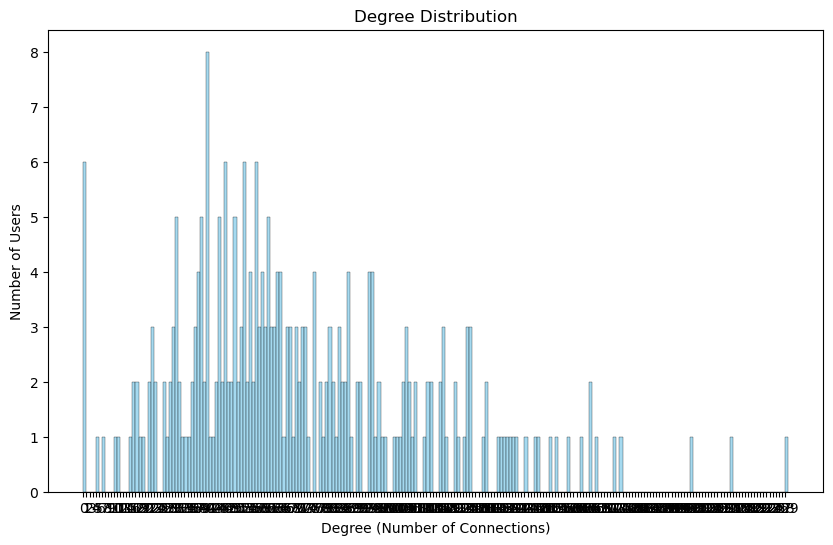

In [40]:
# Calculate degree for each node
degree_dict = dict(G.degree())

# Convert to DataFrame
df_degree = pd.DataFrame(list(degree_dict.items()), columns=['username', 'degree'])

# Display descriptive statistics
print("Degree Descriptive Statistics:")
display(df_degree['degree'].describe())

# Plot degree distribution
plt.figure(figsize=(10,6))
sns.histplot(df_degree['degree'], bins=range(df_degree['degree'].min(), df_degree['degree'].max() + 2), kde=False, color='skyblue', edgecolor='black')
plt.title('Degree Distribution')
plt.xlabel('Degree (Number of Connections)')
plt.ylabel('Number of Users')
plt.xticks(range(df_degree['degree'].min(), df_degree['degree'].max() + 1))
plt.show()


### 2. Top Connected Users
Identify users with the highest number of connections, which can be indicative of influential members within the network.

In [47]:
def censor_name(name):
    if len(name) <= 3:
        return name[0] + '*' * (len(name) - 1)  # For short names
    return name[0] + '*' * (len(name) - 2) + name[-1]  # Mask middle part

# Top 10 users by degree
top_degree = df_degree.sort_values(by='degree', ascending=False).head(10)
top_degree['username'] = top_degree['username'].apply(censor_name)
print("Top 10 Users by Degree:")
display(top_degree)


Top 10 Users by Degree:


username  degree
138          d*******_     229
165      s***********6     211
148          a*******a     198
3      s*************o     175
25            a******p     173
82           s*******0     167
38   m***************o     165
96      h************n     165
39          f********r     162
147           s******s     158

### 3. Privacy Status Distribution
Analyze the distribution of private and public accounts within the network.

Privacy Status Counts:
Public     235
Private     34
Name: is_private, dtype: int64


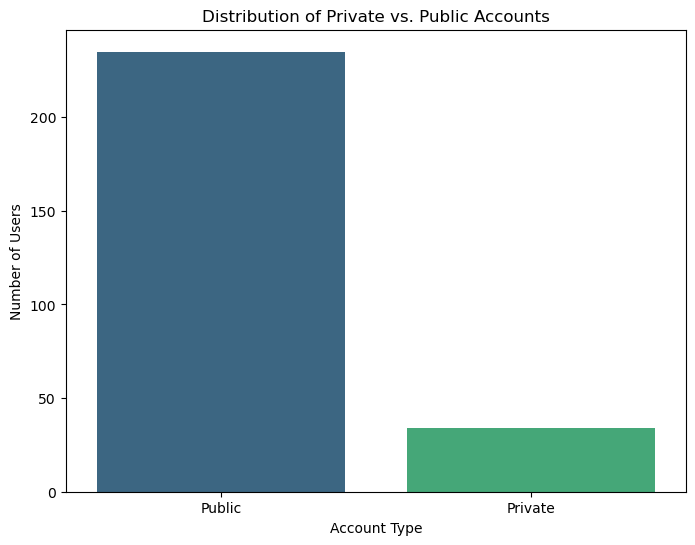

In [48]:
# Count of private vs. public accounts
privacy_counts = df_metadata['is_private'].value_counts().rename(index={False: 'Public', True: 'Private'})

print("Privacy Status Counts:")
print(privacy_counts)

# Visualize the counts
plt.figure(figsize=(8,6))
sns.barplot(x=privacy_counts.index, y=privacy_counts.values, palette='viridis')
plt.title('Distribution of Private vs. Public Accounts')
plt.xlabel('Account Type')
plt.ylabel('Number of Users')
plt.show()


## Graph Visualization

To protect the privacy of Instagram users, we'll anonymize the usernames by assigning each user a unique identifier (e.g., Node 1, Node 2, etc.). This approach ensures that the visualizations do not reveal any personal information.

### 1. Creating a Mapping for Anonymization
First, we'll create a mapping between the actual usernames and their anonymized identifiers.

In [51]:
# Create a mapping from usernames to anonymized IDs
username_list = list(G.nodes())
anonymized_ids = [f'Node {i+1}' for i in range(len(username_list))]
mapping = dict(zip(username_list, anonymized_ids))

# Create a new graph with anonymized node labels
G_anonymized = nx.relabel_nodes(G, mapping)

print(f"Number of nodes in the anonymized graph: {G_anonymized.number_of_nodes()}")
print(f"Number of edges in the anonymized graph: {G_anonymized.number_of_edges()}")


Number of nodes in the anonymized graph: 269
Number of edges in the anonymized graph: 9482


### 2. Basic Graph Plot


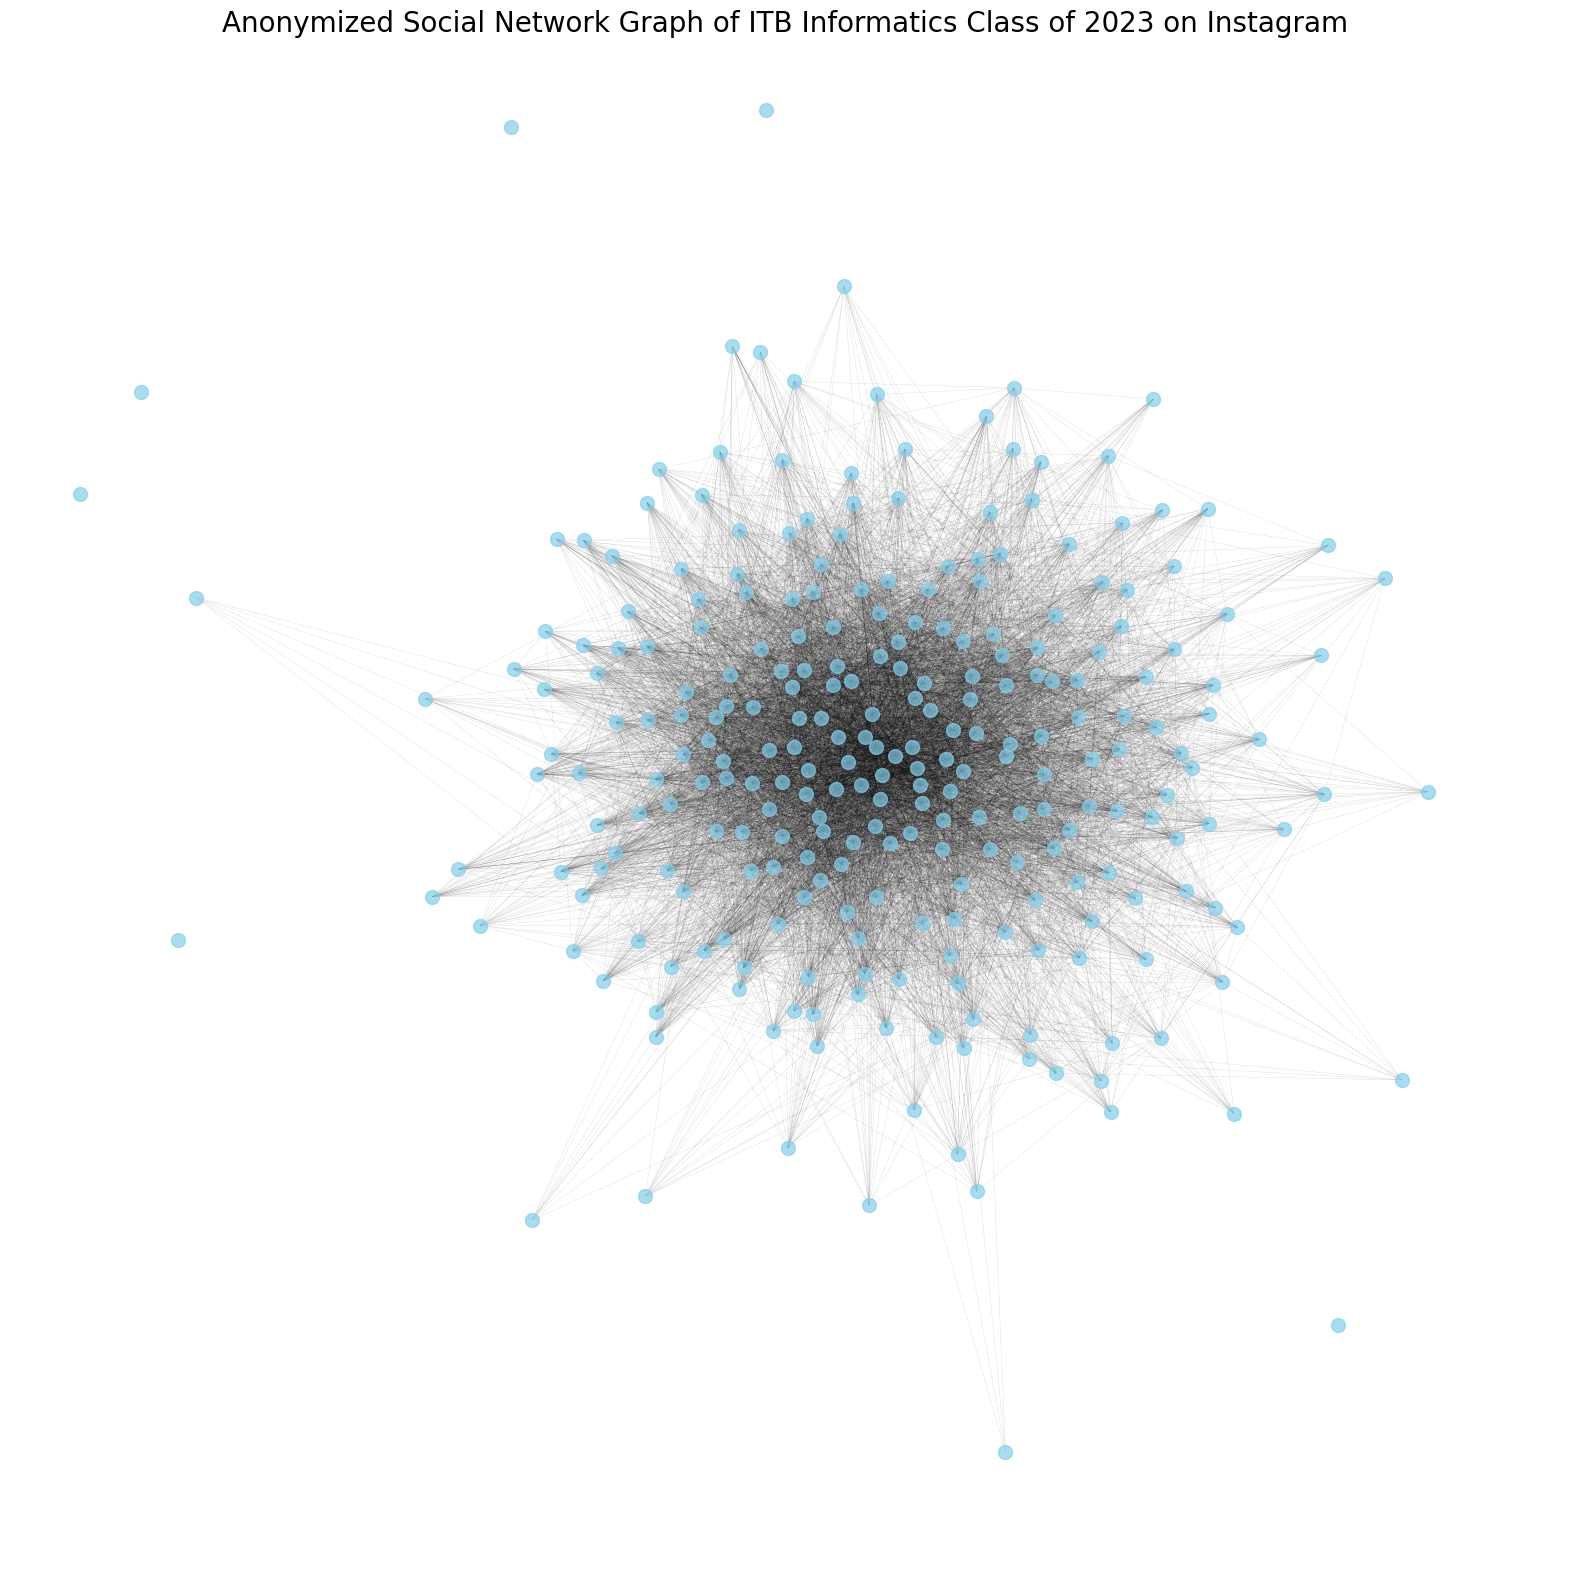

In [54]:
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G_anonymized, k=0.4, iterations=20)  # Spring layout for better visualization
nx.draw_networkx_nodes(G_anonymized, pos, node_size=100, node_color='skyblue', alpha=0.7)
nx.draw_networkx_edges(G_anonymized, pos, width=0.2, alpha=0.2)
# Optionally, omit labels for better privacy
# nx.draw_networkx_labels(G_anonymized, pos, font_size=8)
plt.title('Anonymized Social Network Graph of ITB Informatics Class of 2023 on Instagram', fontsize=20)
plt.axis('off')
plt.show()


### 2. Highlighting Private and Public Accounts (Anonymized)

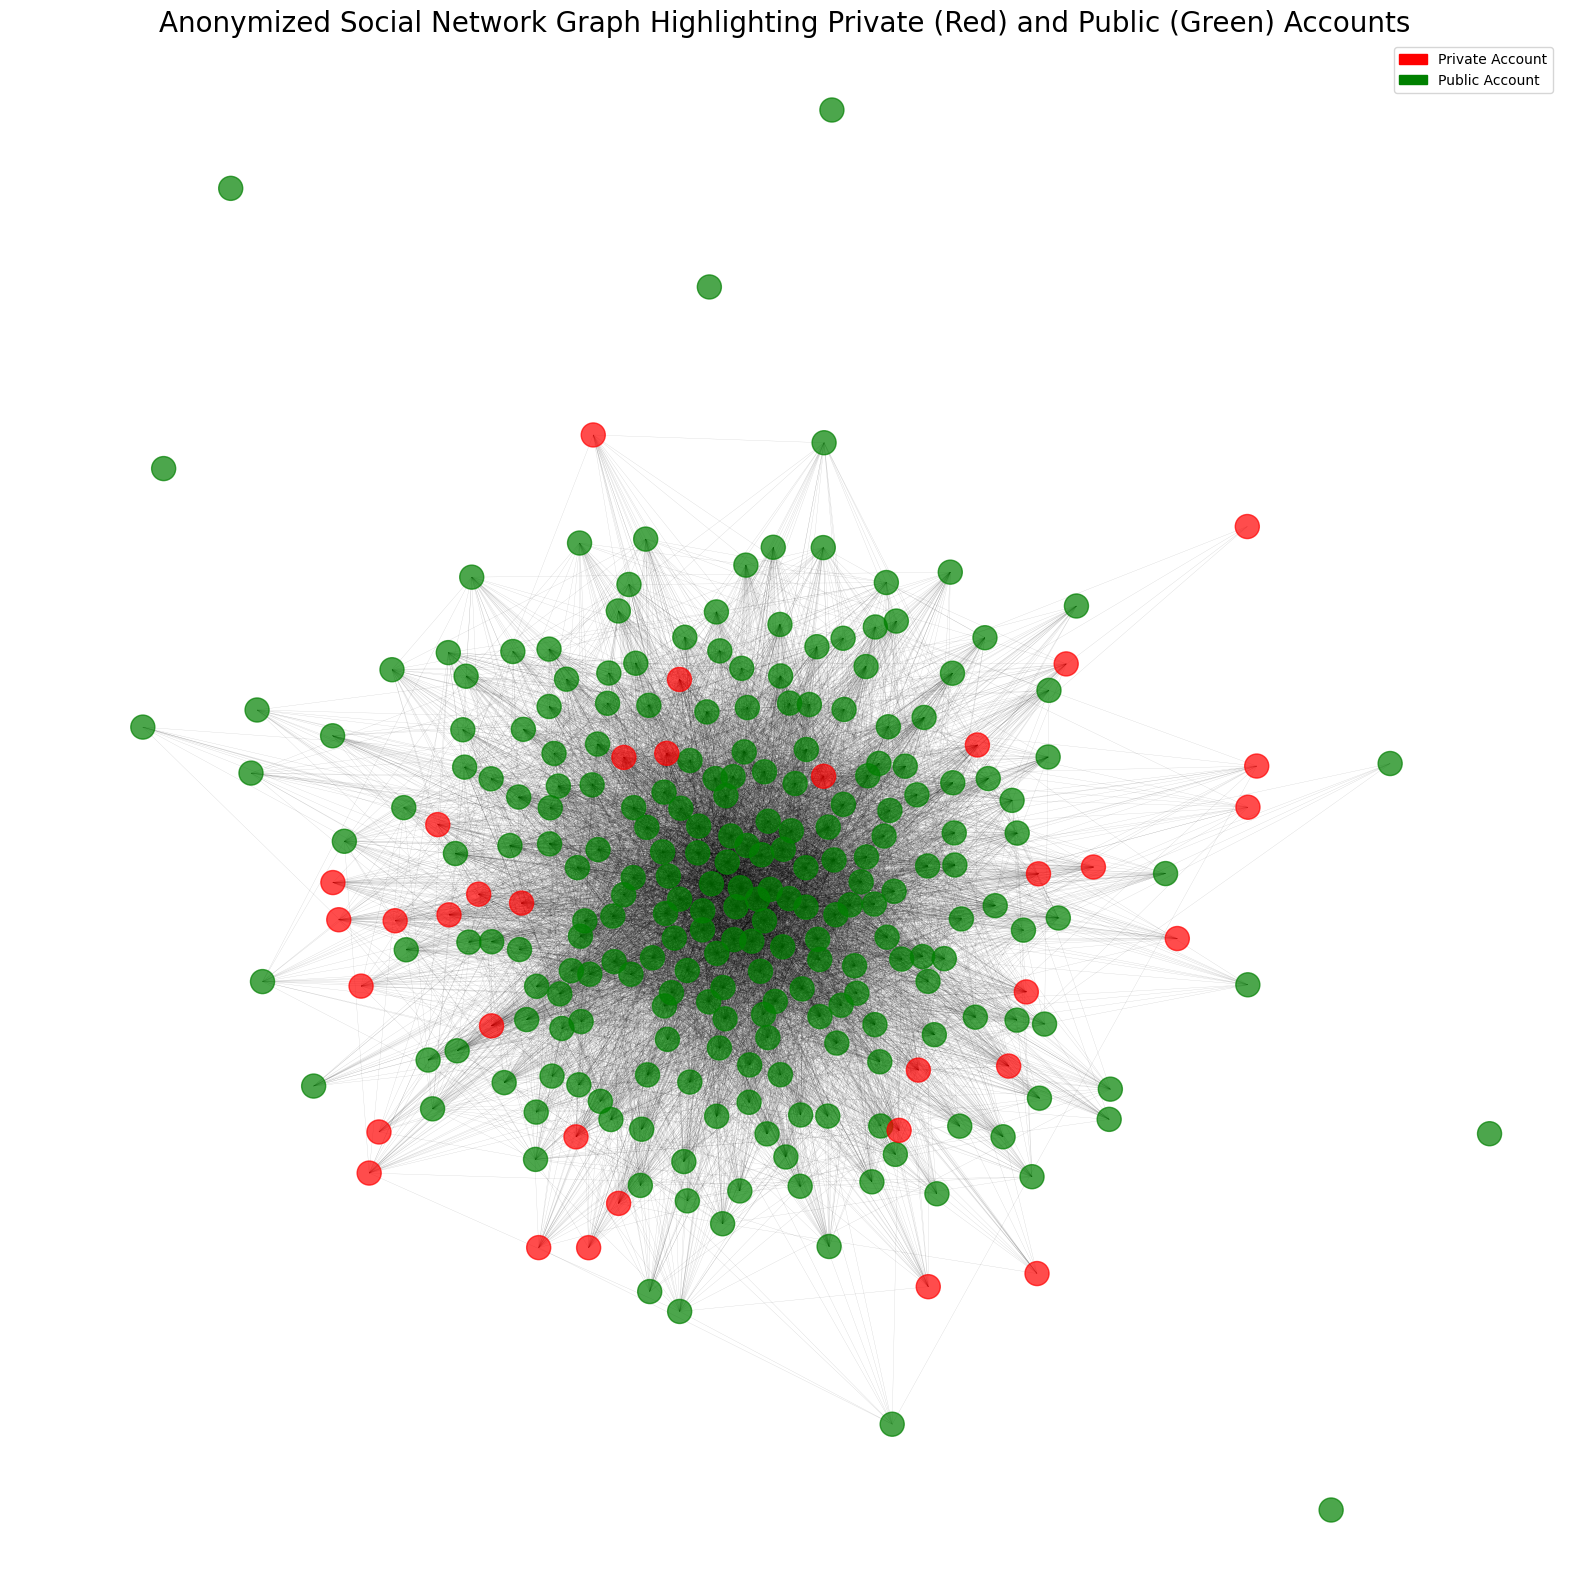

In [56]:
# Assign colors based on 'is_private' attribute
node_colors = ['red' if G_anonymized.nodes[node]['is_private'] else 'green' for node in G_anonymized.nodes()]

plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G_anonymized, k=0.4, iterations=20)
nx.draw_networkx_nodes(G_anonymized, pos, node_size=300, node_color=node_colors, alpha=0.7)
nx.draw_networkx_edges(G_anonymized, pos, width=0.2, alpha=0.2)
# Optionally, omit labels for better privacy
# nx.draw_networkx_labels(G_anonymized, pos, font_size=8)
plt.title('Anonymized Social Network Graph Highlighting Private (Red) and Public (Green) Accounts', fontsize=20)
plt.axis('off')

# Create a legend
import matplotlib.patches as mpatches

private_patch = mpatches.Patch(color='red', label='Private Account')
public_patch = mpatches.Patch(color='green', label='Public Account')
plt.legend(handles=[private_patch, public_patch], loc='best')
plt.show()


### 3. Community Visualization (Anonymized)
Identify and visualize communities within the network to uncover subgroups or clusters using the Louvain Method, which is more efficient and often more effective than the Girvan-Newman algorithm for larger networks.

In [71]:
!pip install python-louvain


     ------------------------------------ 204.6/204.6 kB 443.8 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9403 sha256=8e48059a8d28fc42c22865adabb8de0ece292fa3e4a03f1d0574b4105c3cebb1
  Stored in directory: c:\users\refki\appdata\local\pip\cache\wheels\e0\2c\33\8b5604f69c4a6ed10fb867d51173c03f666920c7c8bbcedbaa
Successfully built python-louvain



Detecting communities using the Louvain method...

Number of communities detected: 11


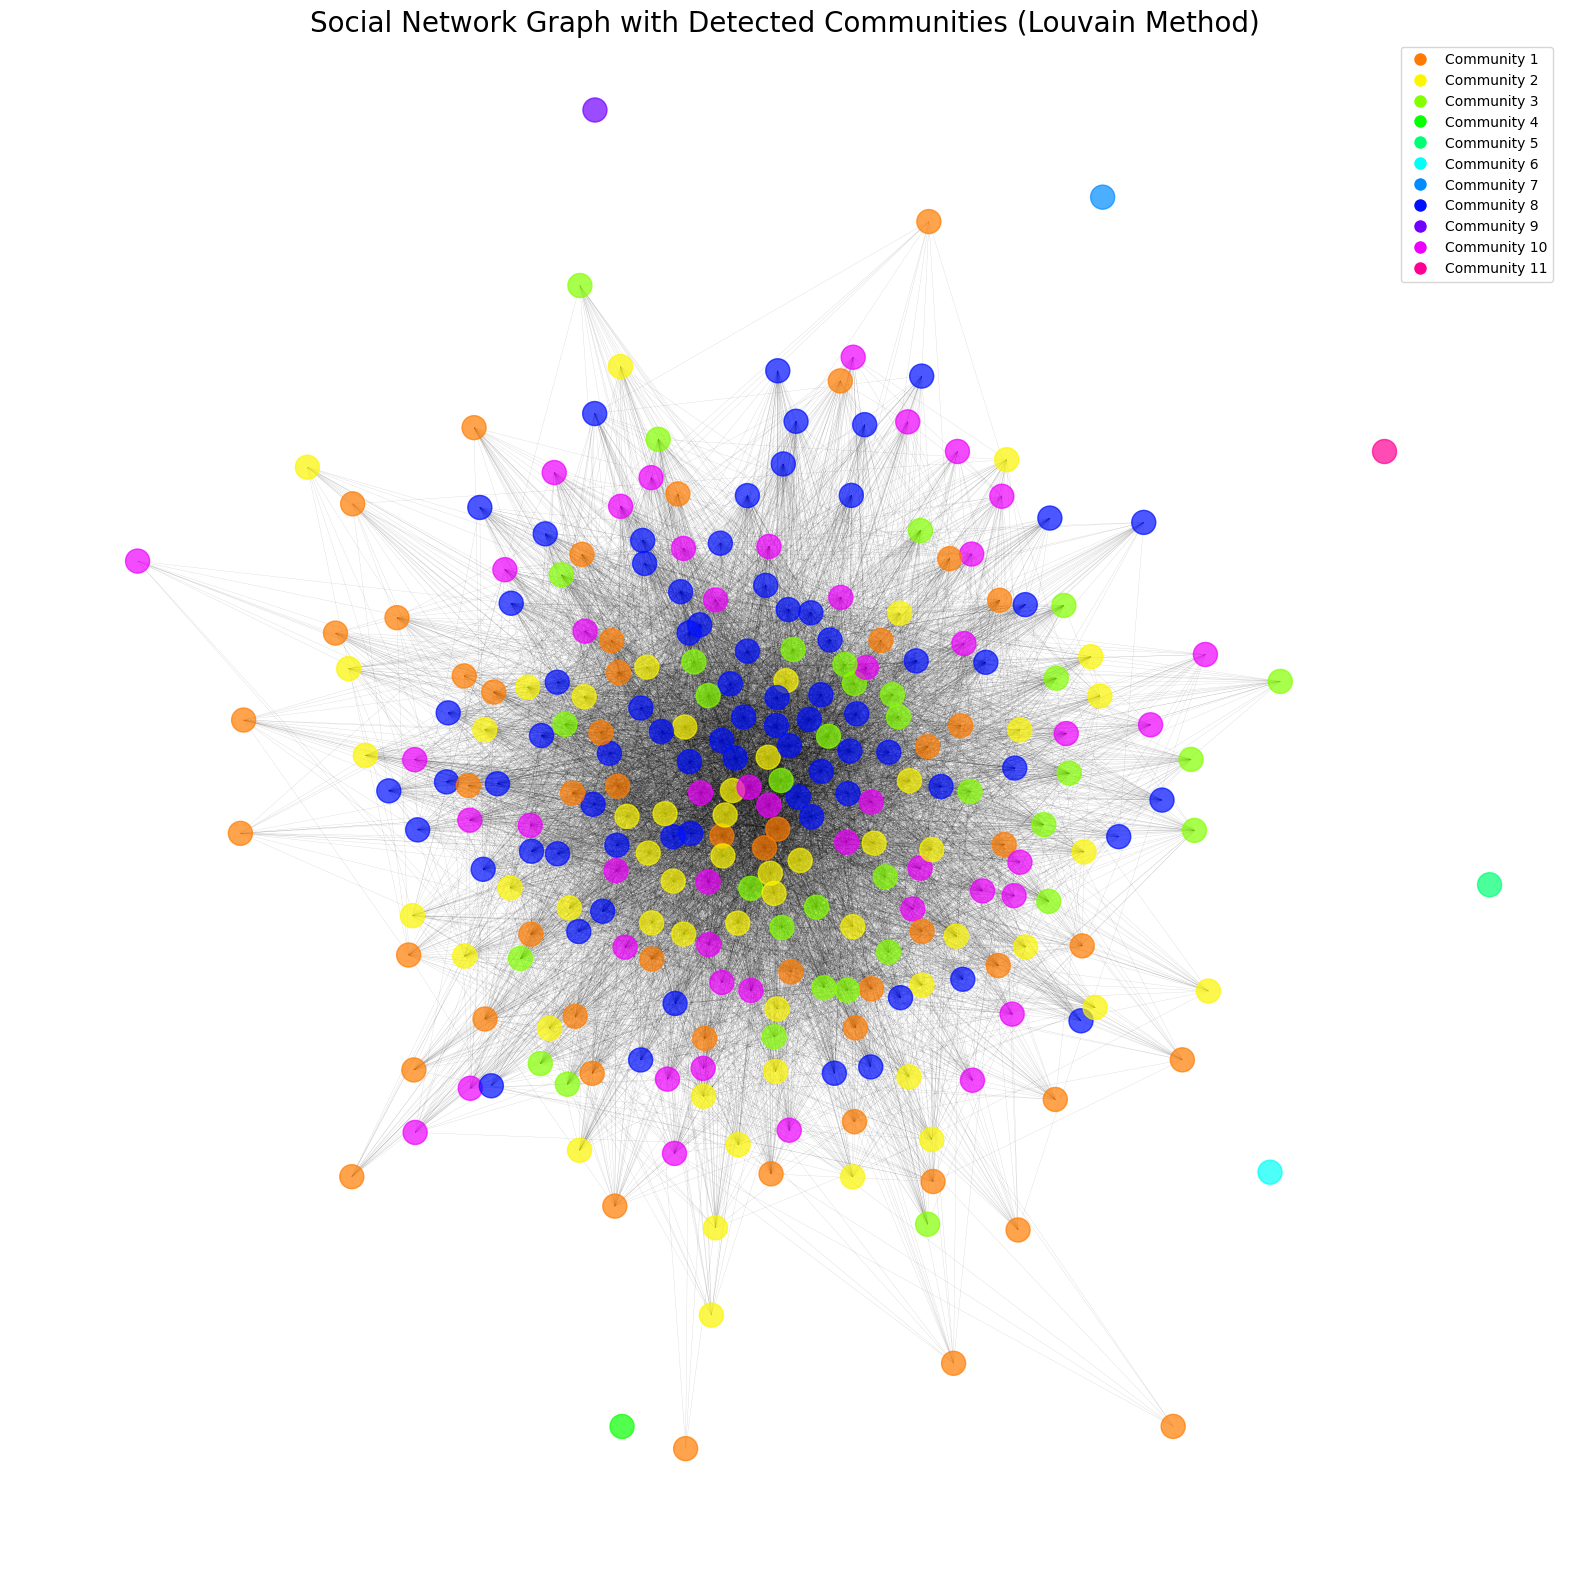

In [76]:
import community as community_louvain  # Ensure you have python-louvain installed: pip install python-louvain

# Detect communities using the Louvain method
print("\nDetecting communities using the Louvain method...")
partition = community_louvain.best_partition(G_anonymized)

# Number of communities detected
num_communities = len(set(partition.values()))
print(f"\nNumber of communities detected: {num_communities}")

# Assign colors to communities
cmap = sns.color_palette("hsv", num_communities)
community_colors = {node: cmap[comm] for node, comm in partition.items()}

# Generate colors list for nodes
colors = [community_colors.get(node, 'black') for node in G_anonymized.nodes()]

plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G_anonymized, k=0.5, iterations=20)
nx.draw_networkx_nodes(G_anonymized, pos, node_size=300, node_color=colors, alpha=0.7)
nx.draw_networkx_edges(G_anonymized, pos, width=0.2, alpha=0.2)
# Omit labels for enhanced privacy
plt.title('Social Network Graph with Detected Communities (Louvain Method)', fontsize=20)
plt.axis('off')


# Create a legend for communities
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Community {i+1}',
                          markerfacecolor=cmap[i], markersize=10) for i in range(num_communities)]
plt.legend(handles=legend_elements, loc='best')
plt.show()


## Graph Analysis

### 1. Degree Centrality

In [61]:
# Calculate degree centrality on the anonymized graph
degree_centrality_anonymized = nx.degree_centrality(G_anonymized)

# Convert to DataFrameD
df_degree_centrality_anonymized = pd.DataFrame(list(degree_centrality_anonymized.items()), columns=['Node', 'Degree Centrality'])
df_degree_centrality_anonymized = df_degree_centrality_anonymized.sort_values(by='Degree Centrality', ascending=False)

print("\nTop 5 Nodes by Degree Centrality:")
display(df_degree_centrality_anonymized.head(5))



Top 5 Nodes by Degree Centrality:


Node  Degree Centrality
138  Node 139           0.854478
165  Node 166           0.787313
148  Node 149           0.738806
3      Node 4           0.652985
25    Node 26           0.645522

### 2. Betweenness Centrality


In [62]:
# Calculate betweenness centrality on the anonymized graph
betweenness_centrality_anonymized = nx.betweenness_centrality(G_anonymized)

# Convert to DataFrame
df_betweenness_anonymized = pd.DataFrame(list(betweenness_centrality_anonymized.items()), columns=['Node', 'Betweenness Centrality'])
df_betweenness_anonymized = df_betweenness_anonymized.sort_values(by='Betweenness Centrality', ascending=False)

print("\nTop 5 Nodes by Betweenness Centrality:")
display(df_betweenness_anonymized.head(5))



Top 5 Nodes by Betweenness Centrality:


Node  Betweenness Centrality
138  Node 139                0.037661
165  Node 166                0.035603
148  Node 149                0.019881
96    Node 97                0.014244
3      Node 4                0.013986

### 3. Closeness Centrality

In [63]:
# Calculate closeness centrality on the anonymized graph
closeness_centrality_anonymized = nx.closeness_centrality(G_anonymized)

# Convert to DataFrame
df_closeness_anonymized = pd.DataFrame(list(closeness_centrality_anonymized.items()), columns=['Node', 'Closeness Centrality'])
df_closeness_anonymized = df_closeness_anonymized.sort_values(by='Closeness Centrality', ascending=False)

print("\nTop 5 Nodes by Closeness Centrality:")
display(df_closeness_anonymized.head(5))



Top 5 Nodes by Closeness Centrality:


Node  Closeness Centrality
138  Node 139              0.868252
165  Node 166              0.818321
148  Node 149              0.785688
3      Node 4              0.733909
25    Node 26              0.729727

### 4. Identifying Communities

In [74]:
import community as community_louvain  # Ensure you have python-louvain installed: pip install python-louvain

# Detect communities using the Louvain method
print("\nDetecting communities using the Louvain method...")
partition = community_louvain.best_partition(G_anonymized)

# Number of communities detected
num_communities = len(set(partition.values()))
print(f"\nNumber of communities detected: {num_communities}")

# Organize nodes by community
communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = []
    communities[community_id].append(node)

# Print communities
print("Communities:")
for i, (community_id, nodes) in enumerate(sorted(communities.items()), 1):
    print(f"Community {i}: {sorted(nodes)}")


Detecting communities using the Louvain method...

Number of communities detected: 10
Communities:
Community 1: ['Node 1', 'Node 101', 'Node 102', 'Node 103', 'Node 108', 'Node 110', 'Node 112', 'Node 114', 'Node 116', 'Node 118', 'Node 119', 'Node 12', 'Node 125', 'Node 126', 'Node 129', 'Node 133', 'Node 134', 'Node 142', 'Node 148', 'Node 159', 'Node 161', 'Node 163', 'Node 164', 'Node 165', 'Node 167', 'Node 170', 'Node 172', 'Node 173', 'Node 176', 'Node 177', 'Node 178', 'Node 18', 'Node 183', 'Node 187', 'Node 192', 'Node 195', 'Node 2', 'Node 209', 'Node 21', 'Node 219', 'Node 220', 'Node 221', 'Node 238', 'Node 247', 'Node 254', 'Node 255', 'Node 256', 'Node 257', 'Node 26', 'Node 260', 'Node 261', 'Node 264', 'Node 266', 'Node 267', 'Node 29', 'Node 38', 'Node 4', 'Node 40', 'Node 46', 'Node 47', 'Node 48', 'Node 5', 'Node 54', 'Node 58', 'Node 62', 'Node 65', 'Node 66', 'Node 72', 'Node 75', 'Node 80', 'Node 83', 'Node 85', 'Node 90', 'Node 91', 'Node 93', 'Node 96', 'Node 

### 5. Network Density

In [65]:
density_anonymized = nx.density(G_anonymized)
print(f"\nNetwork Density: {density_anonymized:.4f}")



Network Density: 0.2631


### 6. Average Path Length


In [66]:
if nx.is_connected(G_anonymized):
    avg_path_length_anonymized = nx.average_shortest_path_length(G_anonymized)
    print(f"\nAverage Path Length: {avg_path_length_anonymized:.4f}")
else:
    print("\nGraph is not connected. Calculating average path length for each connected component.")
    connected_components_anonymized = nx.connected_components(G_anonymized)
    avg_path_lengths_anonymized = {}
    for i, component in enumerate(connected_components_anonymized, 1):
        subgraph = G_anonymized.subgraph(component)
        if len(subgraph) > 1:
            avg_length = nx.average_shortest_path_length(subgraph)
            avg_path_lengths_anonymized[f'Component {i}'] = avg_length
    print("Average Path Lengths for Connected Components:")
    for component, length in avg_path_lengths_anonymized.items():
        print(f"{component}: {length:.4f}")



Graph is not connected. Calculating average path length for each connected component.
Average Path Lengths for Connected Components:
Component 1: 1.7263
